In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [71]:
# Read confirmed cases
df_cases_raw = pd.read_csv(os.path.join('data','cases.csv'))        # read csv
df_cases_raw = df_cases_raw.query(" location == 'Bogotá D.C.-Bogotá d C.' ")    # get only for Bogotá
df_cases_raw['date_time'] = pd.to_datetime(df_cases_raw['date_time'], format='%Y-%m-%d')    # converted to datetime
df_cases_raw

,date_time,location,poly_id,num_cases,num_diseased,num_recovered,num_infected,num_infected_in_hospital,num_infected_in_house
11789,2020-03-06,Bogotá D.C.-Bogotá d C.,11001,1.0,0.0,0.0,1.0,0.0,1.0
11790,2020-03-11,Bogotá D.C.-Bogotá d C.,11001,2.0,0.0,0.0,2.0,0.0,2.0
11791,2020-03-12,Bogotá D.C.-Bogotá d C.,11001,2.0,0.0,0.0,2.0,0.0,2.0
11792,2020-03-13,Bogotá D.C.-Bogotá d C.,11001,1.0,0.0,0.0,1.0,0.0,1.0
11793,2020-03-14,Bogotá D.C.-Bogotá d C.,11001,10.0,0.0,0.0,10.0,0.0,10.0
...,...,...,...,...,...,...,...,...,...
12181,2021-04-06,Bogotá D.C.-Bogotá d C.,11001,2802.0,4.0,0.0,2798.0,39.0,2759.0
12182,2021-04-07,Bogotá D.C.-Bogotá d C.,11001,2507.0,7.0,0.0,2500.0,51.0,2449.0
12183,2021-04-08,Bogotá D.C.-Bogotá d C.,11001,2543.0,4.0,0.0,2538.0,38.0,2500.0
12184,2021-04-09,Bogotá D.C.-Bogotá d C.,11001,2120.0,0.0,0.0,2120.0,28.0,2092.0


In [72]:
# Perform rolling average over data
rolling_window_size = 7     # days
date_times = df_cases_raw['date_time'].tolist()

# Get data of interest
confirmed_cases = df_cases_raw['num_cases'].rolling(window=rolling_window_size).mean().tolist()
confirmed_deaths = df_cases_raw['num_diseased'].rolling(window=rolling_window_size).mean().tolist()
confirmed_hospital = df_cases_raw['num_infected_in_hospital'].rolling(window=rolling_window_size).mean().tolist()
confirmed_house = df_cases_raw['num_infected_in_house'].rolling(window=rolling_window_size).mean().tolist()

dict_cases = dict(zip(['date_time','confirmed_cases','confirmed_deaths','confirmed_hospital','confirmed_house'],
                      [date_times,confirmed_cases,confirmed_deaths,confirmed_hospital,confirmed_house]))

df_cases = pd.DataFrame(data=dict_cases)
df_cases

,date_time,confirmed_cases,confirmed_deaths,confirmed_hospital,confirmed_house
0,2020-03-06,NaN,NaN,NaN,NaN
1,2020-03-11,NaN,NaN,NaN,NaN
2,2020-03-12,NaN,NaN,NaN,NaN
3,2020-03-13,NaN,NaN,NaN,NaN
4,2020-03-14,NaN,NaN,NaN,NaN
...,...,...,...,...,...
392,2021-04-06,1756.428571,11.000000,70.000000,1675.285714
393,2021-04-07,1847.285714,10.857143,65.714286,1770.571429
394,2021-04-08,2027.000000,9.857143,62.571429,1954.428571
395,2021-04-09,2128.000000,8.571429,53.714286,2065.571429


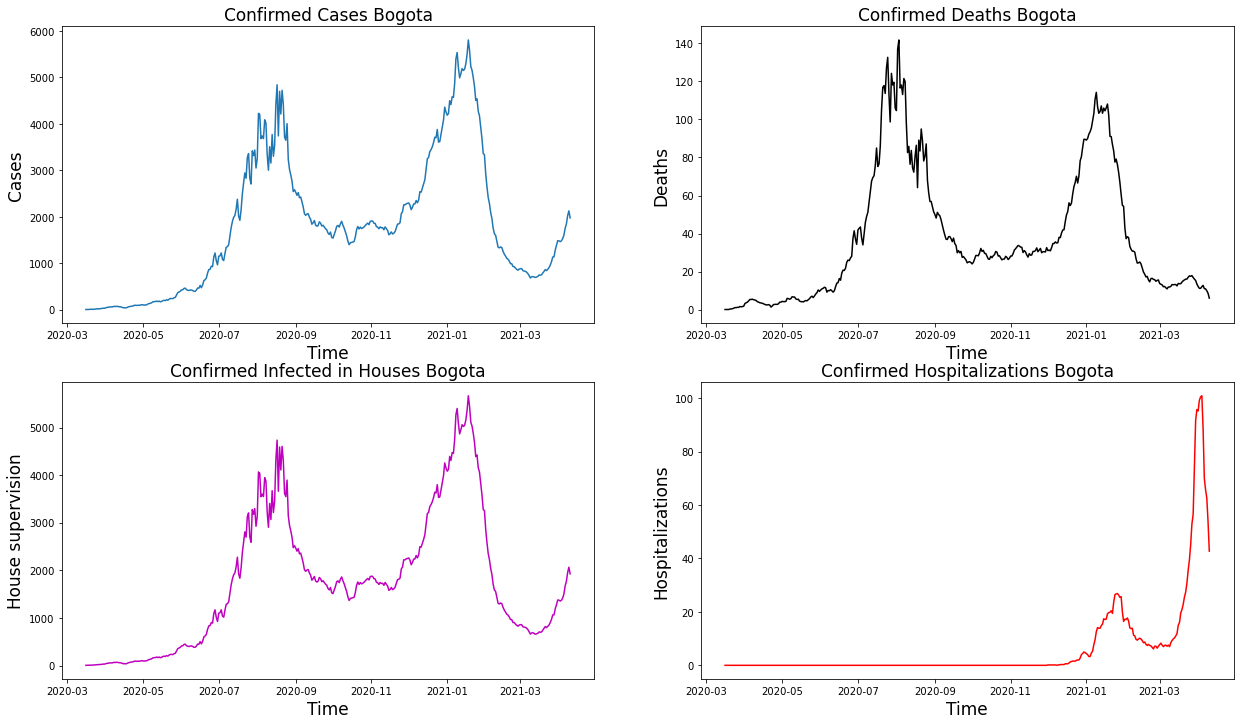

In [82]:
fig,ax = plt.subplots(2,2,figsize=(7*3, 6*2))

sns.lineplot(ax=ax[0,0], data=df_cases,x='date_time',y='confirmed_cases')
ax[0,0].set_xlabel('Time',fontsize=17)
ax[0,0].set_ylabel('Cases',fontsize=17)
ax[0,0].set_title('Confirmed Cases Bogota',fontsize=17)

sns.lineplot(ax=ax[0,1], data=df_cases,x='date_time',y='confirmed_deaths',color='k')
ax[0,1].set_xlabel('Time',fontsize=17)
ax[0,1].set_ylabel('Deaths',fontsize=17)
ax[0,1].set_title('Confirmed Deaths Bogota',fontsize=17)

sns.lineplot(ax=ax[1,0], data=df_cases,x='date_time',y='confirmed_house',color='m')
ax[1,0].set_xlabel('Time',fontsize=17)
ax[1,0].set_ylabel('House supervision',fontsize=17)
ax[1,0].set_title('Confirmed Infected in Houses Bogota',fontsize=17)

sns.lineplot(ax=ax[1,1], data=df_cases,x='date_time',y='confirmed_hospital',color='r')
ax[1,1].set_xlabel('Time',fontsize=17)
ax[1,1].set_ylabel('Hospitalizations',fontsize=17)
ax[1,1].set_title('Confirmed Hospitalizations Bogota',fontsize=17)

plt.show()